### Анализ данных о жилищных объявлениях

C помощью pandahouse попробуем выгрузить нужные данные из ClickHouse и проанализируем их в python. 

На этот раз новый датасет, содержащий информацию об объявлениях на Airbnb в Лондоне 🇬🇧.

* ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах; поскольку столбцов очень много, нужные перечислены в текстах самих задач

In [ ]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as plt

In [3]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }


# connection_test = dict(database='test',
#                   host='http://clickhouse.beslan.pro:8080',
#                   user='student-rw',
#                   password='656e2b0c9c')

In [1]:
#Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос:
#выведите количество строк в таблице ldn_listings.

In [11]:
q = '''
SELECT COUNT(*)
FROM default.ldn_listings
'''

q_df = ph.read_clickhouse(query=q, connection=connection_default)
q_df

,count()
0,85207


In [2]:
#Выгрузите из таблицы данные о цене в зависимости от типа жилья.
#Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

#В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [14]:
q1 = '''
SELECT 
    id,
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price,
    room_type
FROM default.ldn_listings
ORDER BY id ASC
LIMIT 1000
'''

q1_df = ph.read_clickhouse(query=q1, connection=connection_default)
q1_df

,id,price,room_type
0,13913,65.0,Private room
1,15400,100.0,Entire home/apt
2,17402,300.0,Entire home/apt
3,17506,150.0,Private room
4,25023,65.0,Entire home/apt
...,...,...,...
995,541081,110.0,Entire home/apt
996,541363,110.0,Entire home/apt
997,542231,65.0,Private room
998,542646,100.0,Entire home/apt


In [19]:
q1_df.groupby('room_type',as_index=False)\
    .quantile(q=0.75)

,room_type,id,price
0,Entire home/apt,463610.50,160.00
1,Hotel room,73302.50,157.00
2,Private room,453442.50,70.00
3,Shared room,472261.75,69.25


In [3]:
#К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating).
#Среди представленных графиков выберите корректный

In [29]:
q2 = '''
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price,
    toFloat32OrZero(review_scores_rating) as review_scores_rating
FROM default.ldn_listings
WHERE review_scores_rating != 0
ORDER BY id ASC
LIMIT 1000
'''

q2_df = ph.read_clickhouse(query=q2, connection=connection_default)
q2_df

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [32]:
q2_df_for_plot = q2_df.groupby('room_type',as_index=False)\
    .agg({'price' : 'mean', 'review_scores_rating' : 'mean'})
q2_df_for_plot

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


<AxesSubplot:xlabel='price', ylabel='review_scores_rating'>

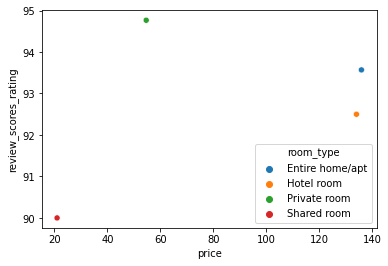

In [35]:
sns.scatterplot(data=q2_df_for_plot, x="price", y="review_scores_rating", hue="room_type")

In [4]:
#Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.
#Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). 

#Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [104]:
q3 = '''
SELECT 
    DISTINCT host_id,
    host_verifications
FROM default.ldn_listings
WHERE experiences_offered != 'none'
'''

q3_df = ph.read_clickhouse(query=q3, connection=connection_default)
q3_df

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [105]:
q3_df['host_verifications'] = q3_df.host_verifications.str.strip('[] ').str.replace("'","").str.split(", ")

In [106]:
q3_df

,host_id,host_verifications
0,54730,"[email, phone, facebook, reviews, offline_gove..."
1,60302,"[email, phone, reviews, jumio, government_id]"
2,67915,"[email, phone, jumio, selfie, government_id, i..."
3,167107,"[email, phone, manual_offline, jumio, offline_..."
4,103583,"[email, phone, reviews, offline_government_id,..."
...,...,...
1356,21558962,"[email, phone, reviews, jumio, government_id]"
1357,21257846,"[email, phone, reviews, jumio, offline_governm..."
1358,34219613,"[email, phone, reviews, jumio, government_id]"
1359,34299581,"[email, phone, google, reviews, jumio, offline..."


In [107]:
q3_df.host_verifications[0]

['email',
 'phone',
 'facebook',
 'reviews',
 'offline_government_id',
 'selfie',
 'government_id']

In [108]:
q3_df = q3_df.explode('host_verifications')
q3_df

,host_id,host_verifications
0,54730,email
0,54730,phone
0,54730,facebook
0,54730,reviews
0,54730,offline_government_id
...,...,...
1360,26917573,phone
1360,26917573,reviews
1360,26917573,manual_offline
1360,26917573,jumio


In [109]:
q3_df.host_verifications.value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [110]:
q3_df.host_verifications.unique()

array(['email', 'phone', 'facebook', 'reviews', 'offline_government_id',
       'selfie', 'government_id', 'jumio', 'identity_manual',
       'work_email', 'manual_offline', 'kba', 'google', 'sent_id',
       'manual_online'], dtype=object)

In [5]:
#Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. 
#Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений.
#Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

#Какой график получился?

In [112]:
q4 = '''
SELECT 
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(host_id) AS experiences_count
FROM default.ldn_listings
WHERE experiences_offered != 'none'
GROUP BY
    neighbourhood_cleansed, 
    experiences_offered
ORDER BY
    experiences_count DESC
LIMIT 100
'''

q4_df = ph.read_clickhouse(query=q4, connection=connection_default)
q4_df

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [113]:
q4_df_pivot = q4_df.pivot(index = 'neighbourhood_cleansed', columns = 'experiences_offered', values = 'experiences_count')

In [114]:
q4_df_pivot

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


<AxesSubplot:xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

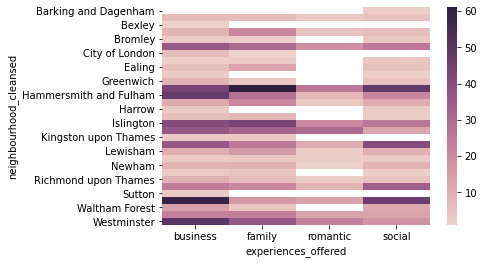

In [115]:
sns.heatmap(data = q4_df_pivot , cmap=sns.cubehelix_palette(as_cmap=True))

In [6]:
#Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. 
#Далее постройте два графика, используя distplot из библиотеки seaborn:
#На первом отобразите исходные распределения цен для каждого типа жилья
#На втором – логарифмированные значения (np.log())

In [117]:
q5 = '''
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price
FROM default.ldn_listings
WHERE experiences_offered != 'none'
'''

q5_df = ph.read_clickhouse(query=q5, connection=connection_default)
q5_df

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


In [131]:
sns.set(
    font_scale=2,
    style="whitegrid",
        )

TypeError: 'module' object is not callable

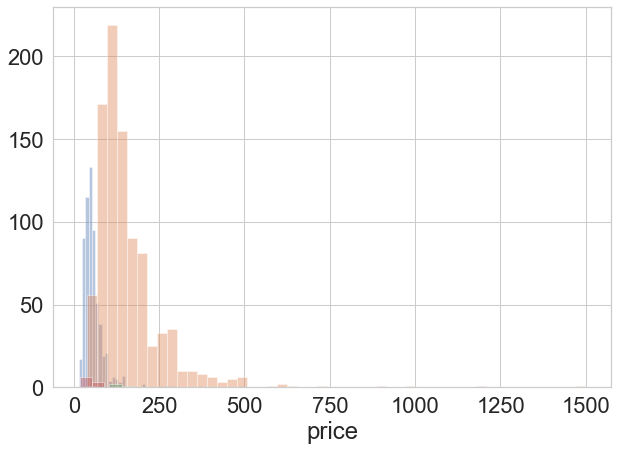

In [132]:
sns.distplot((q5_df.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot((q5_df.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot((q5_df.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot((q5_df.query("room_type=='Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

TypeError: 'module' object is not callable

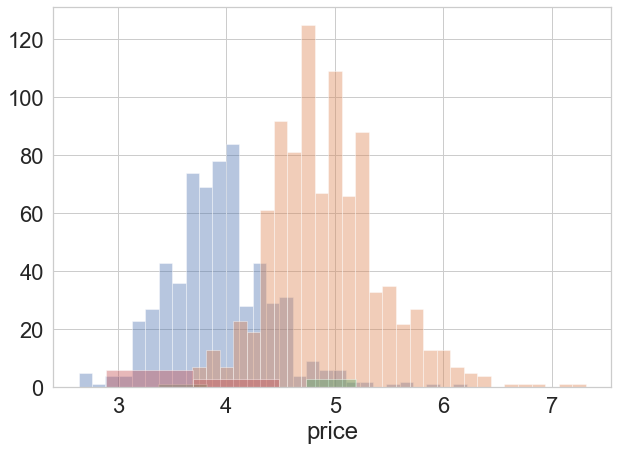

In [134]:
sns.distplot((np.log(q5_df.query("room_type=='Private room'").price)), kde=False, label='Private room')
sns.distplot((np.log(q5_df.query("room_type=='Entire home/apt'").price)), kde=False, label='Entire home/apt')
sns.distplot((np.log(q5_df.query("room_type=='Hotel room'").price)), kde=False, label='Hotel room')
sns.distplot((np.log(q5_df.query("room_type=='Shared room'").price)), kde=False, label='Shared room')
plt.legend()
plt.show()

In [7]:
#Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. 
#Используя библиотеку seaborn и функцию lineplot, 
#постройте график динамики средних цен на жилье в зависимости от типа комнаты по годам.

In [136]:
q6 = '''
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price,
    first_review 
FROM default.ldn_listings
WHERE first_review  > '2010-01-01'
LIMIT 1000
'''

q6_df = ph.read_clickhouse(query=q6, connection=connection_default)
q6_df

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [140]:
q6_df['first_review'] = pd.to_datetime(q6_df['first_review'])

In [142]:
q6_df['first_review'] = q6_df['first_review'].dt.year

In [144]:
q6_df = q6_df.rename(columns = {'first_review':'year'})

In [150]:
q6_df = q6_df.groupby(['room_type','year']).agg({'price' : 'mean'})

In [151]:
q6_df

price
room_type       year            
Entire home/apt 2010  103.500000
                2011  128.792450
                2012  135.467255
                2013  137.887634
                2014  154.583328
                2015  159.380951
                2016   99.733330
                2017  111.666664
                2018  125.066666
                2019  301.666656
                2020   50.000000
Hotel room      2010   88.000000
                2017  180.000000
Private room    2010   56.428570
                2011   52.607143
                2012   53.269840
                2013   57.036587
                2014   56.842106
                2015   48.058823
                2016   57.307693
                2017   51.142857
                2018   55.416668
                2019   74.000000
                2020   39.000000
Shared room     2012   22.000000
                2014   20.000000

<AxesSubplot:xlabel='year', ylabel='price'>

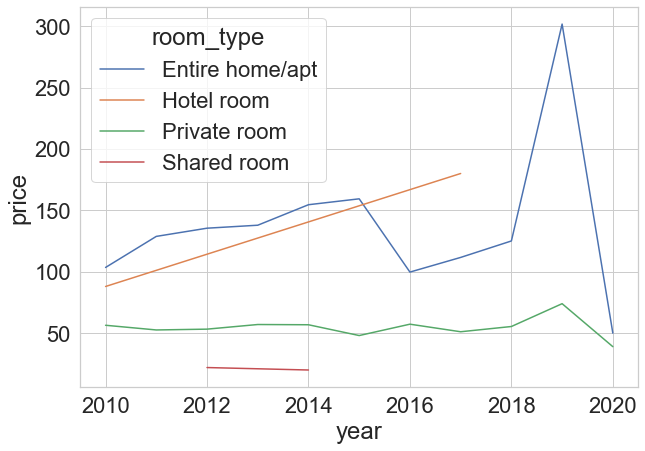

In [152]:
sns.lineplot(data=q6_df, x="year", y="price", hue="room_type")